In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "datasets/wv_3d_blob_2"

In [3]:
train_features = pickle.load(open(f"{data_dir}/train_features.pkl","rb"))
valid_features = pickle.load(open(f"{data_dir}/valid_features.pkl","rb"))
test_features = pickle.load(open(f"{data_dir}/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder(f"{data_dir}/test")])

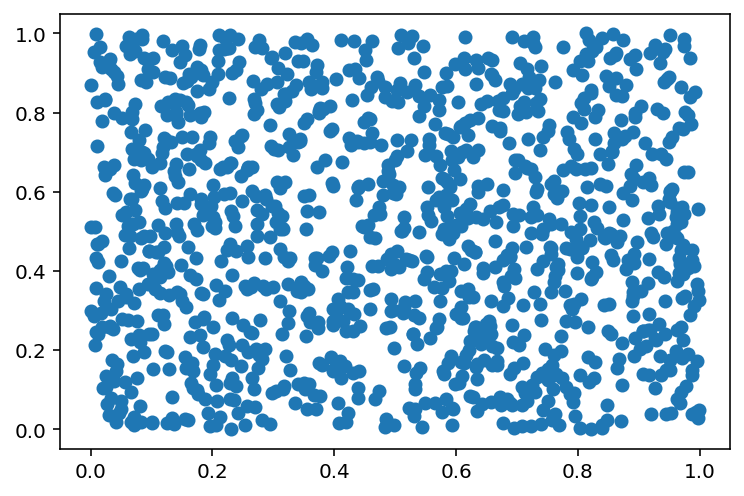

In [24]:
plt.scatter(train_features[:,2],train_features[:,3])

## search alignment

In [25]:
total_weights = np.array(list(itertools.product([0]+[10**i for i in range(6)],repeat=2)))
total_weights = np.hstack([total_weights,np.zeros_like(total_weights)])

In [26]:
aligns = [evals.distorted_1nn(train_features, y_train, test_features, y_test, weights) for weights in total_weights]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0., 42.]),
 array([0.485  , 0.53625, 0.5875 , 0.63875, 0.69   , 0.74125, 0.7925 ,
        0.84375, 0.895  , 0.94625, 0.9975 ]),
 <BarContainer object of 10 artists>)

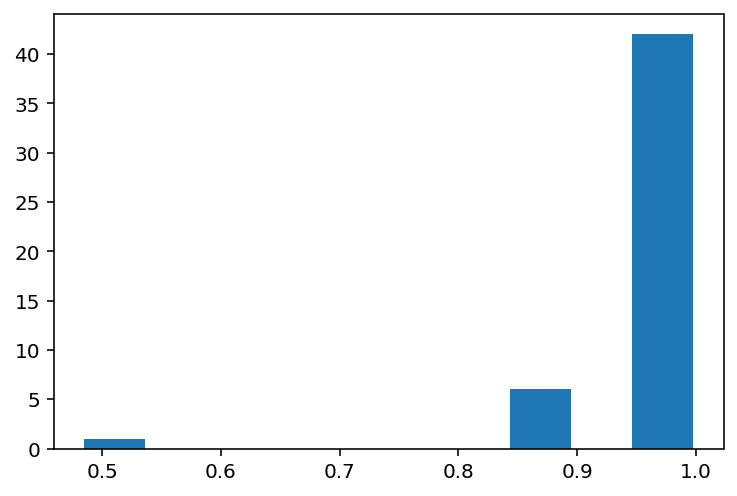

In [27]:
plt.hist(aligns)

In [36]:
np.where(aligns==np.unique(aligns)[5])

(array([22, 30, 38, 46]),)

In [37]:
total_weights[22]

array([100,   1,   0,   0])

In [28]:
np.unique(aligns)

array([0.485 , 0.845 , 0.96  , 0.985 , 0.9875, 0.99  , 0.995 , 0.9975])

In [33]:
evals.distorted_1nn(train_features, y_train, test_features, y_test, [1,1,0,0])

0.9975

#### aligns & filtered

In [39]:
weights = [
    [0,1,0,0],
    [1,100000,0,0],
    [1,0,0,0],
    [100,1,0,0],
    [1,1,0,0]
]
aligns = [0.85,0.96,0.985,0.99,1]
assert(len(weights)==len(aligns))
total = 30000
triplet_dir = "datasets/wv_3d_blob_triplets"

In [40]:
for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    # print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    pathlib.Path(align_dir).mkdir(parents=True, exist_ok=True)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

### noisy

In [41]:
aligns = ["0.85","0.985"]
triplet_dir = "datasets/wv_3d_blob_triplets"

In [42]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = gen.get_noisy_triplets(train_triplets, p)
        valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
        test_noisy = gen.get_noisy_triplets(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [43]:
for align in aligns:    
    for p in np.arange(1,9,1)/10:
        dir = os.path.join(f"{triplet_dir}/align={align}_noisy",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

### nums

In [44]:
aligns = ["0.85","0.985"]
triplet_dir = "datasets/wv_3d_blob_triplets"
def dropout(triplets,p):
    keepers = np.random.choice(np.arange(len(triplets)),int(len(triplets)*p),replace=False)
    return np.array(triplets)[keepers]

In [45]:
for align in aligns:
    train_triplets = pickle.load(open(f"{triplet_dir}/align={align}/train_triplets.pkl","rb"))
    valid_triplets = pickle.load(open(f"{triplet_dir}/align={align}/valid_triplets.pkl","rb"))
    test_triplets = pickle.load(open(f"{triplet_dir}/align={align}/test_triplets.pkl","rb"))
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

        train_noisy = dropout(train_triplets, p)
        valid_noisy = dropout(valid_triplets, p)
        test_noisy = dropout(test_triplets, p)
        pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
        pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
        pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [46]:
for align in aligns:
    for p in [1/128,1/64,1/32,1/16,1/8,1/4,1/2]:
        dir = os.path.join(f"{triplet_dir}/align={align}_num",str(p))
        train_triplets = pickle.load(open(f"{dir}/train_triplets.pkl","rb"))
        valid_triplets = pickle.load(open(f"{dir}/valid_triplets.pkl","rb"))
        test_triplets = pickle.load(open(f"{dir}/test_triplets.pkl","rb"))
        train_triplets_filtered = gen.filter_train_triplets(train_triplets, y_train)
        valid_triplets_filtered = gen.filter_mixed_triplets(valid_triplets, y_train, y_valid)
        test_triplets_filtered = gen.filter_mixed_triplets(test_triplets, y_train, y_test)
        pickle.dump(train_triplets_filtered, open(f"{dir}/train_triplets_filtered.pkl","wb"))
        pickle.dump(valid_triplets_filtered, open(f"{dir}/valid_triplets_filtered.pkl","wb"))
        pickle.dump(test_triplets_filtered, open(f"{dir}/test_triplets_filtered.pkl","wb"))

## yaml generation

In [47]:
weights = [
    [0,1,0,0],
    [1,100000,0,0],
    [1,0,0,0],
    [100,1,0,0],
    [1,1,0,0]
]
aligns = [0.85,0.96,0.985,0.99,1]
yaml_dir = "models/configs/wv_3d_blob/triplets/aligns"

In [36]:
base_align = 0.62
base = oc.load(f"{yaml_dir}/align={base_align}.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base.train_triplets.replace(str(base_align),str(align))
    valid_triplets = base.valid_triplets.replace(str(base_align),str(align))
    test_triplets = base.test_triplets.replace(str(base_align),str(align))
    wandb_group = base.wandb_group.replace(str(base_align),str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"{yaml_dir}/align={align}.yaml")

In [37]:
base_align = 0.62
base = oc.load(f"{yaml_dir}/align={base_align}_filtered.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base.train_triplets.replace(str(base_align),str(align))
    valid_triplets = base.valid_triplets.replace(str(base_align),str(align))
    test_triplets = base.test_triplets.replace(str(base_align),str(align))
    wandb_group = base.wandb_group.replace(str(base_align),str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"{yaml_dir}/align={align}_filtered.yaml")

### noise

In [38]:
aligns = ["0.62","0.97"]
base_p = 0.1
yaml_dir = "models/configs/wv_3d_linear/triplets"
for align in aligns:
    dir = f"{yaml_dir}/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_noisy = oc.load(f"{dir}/p=0.1.yaml")
    for p in np.arange(1,9,1)/10:
        train_triplets = base_noisy.train_triplets.replace(str(base_p),str(p))
        valid_triplets = base_noisy.valid_triplets.replace(str(base_p),str(p))
        test_triplets = base_noisy.test_triplets.replace(str(base_p),str(p))
        wandb_group = base_noisy.wandb_group.replace(str(base_p),str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_noisy,overwrite), f"{dir}/p={p}.yaml")

In [39]:
aligns = ["0.62","0.97"]
base_p = 0.1
for align in aligns:
    dir = f"{yaml_dir}/noisy_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_noisy = oc.load(f"{dir}/p=0.1_filtered.yaml")
    for p in np.arange(1,9,1)/10:
        train_triplets = base_noisy.train_triplets.replace(str(base_p),str(p))
        valid_triplets = base_noisy.valid_triplets.replace(str(base_p),str(p))
        test_triplets = base_noisy.test_triplets.replace(str(base_p),str(p))
        wandb_group = base_noisy.wandb_group.replace(str(base_p),str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_noisy,overwrite), f"{dir}/p={p}_filtered.yaml")

### num

In [40]:
aligns = ["0.62","0.97"]
base_p = 0.5
yaml_dir = "models/configs/wv_3d_linear/triplets"
for align in aligns:
    dir = f"{yaml_dir}/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_num = oc.load(f"{dir}/p={base_p}.yaml")
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        train_triplets = base_num.train_triplets.replace(str(base_p),str(p))
        valid_triplets = base_num.valid_triplets.replace(str(base_p),str(p))
        test_triplets = base_num.test_triplets.replace(str(base_p),str(p))
        wandb_group = base_num.wandb_group.replace(str(base_p),str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_num,overwrite), f"{dir}/p={p}.yaml")

In [41]:
aligns = ["0.62","0.97"]
base_p = 0.5
yaml_dir = "models/configs/wv_3d_linear/triplets"
for align in aligns:
    dir = f"{yaml_dir}/num_{align}" 
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    base_num = oc.load(f"{dir}/p={base_p}_filtered.yaml")
    for p in [1/2, 1/128, 1/64, 1/32,1/16,1/8,1/4]:
        train_triplets = base_num.train_triplets.replace(str(base_p),str(p))
        valid_triplets = base_num.valid_triplets.replace(str(base_p),str(p))
        test_triplets = base_num.test_triplets.replace(str(base_p),str(p))
        wandb_group = base_num.wandb_group.replace(str(base_p),str(p))
        overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
        "test_triplets":test_triplets,"wandb_group":wandb_group}
        oc.save(oc.merge(base_num,overwrite), f"{dir}/p={p}_filtered.yaml")